In [ ]:
# hide
# skip
! [ -e /content ] && pip install -Uqq model_inspector
# For colab. Restart the runtime after running this cell!

In [ ]:
# default_exp inspect

In [ ]:
# export
from functools import partial, update_wrapper
from typing import Iterable, Optional, Sequence, Union
import warnings

from IPython.display import HTML
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import ClassifierMixin, clone, RegressorMixin
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.validation import check_is_fitted
import waterfall_chart

from model_inspector.explore import plot_correlation
from model_inspector.tune import calculate_metrics_by_thresh

# inspect

> Inspect models.

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
# export
# Meant to be colorblind-friendly
COLORS = {"blue": "#377eb8", "orange": "#ff7f00", "green": "#4daf4a", "pink": "#f781bf"}

In [ ]:
# export
def Inspector(model, X: pd.DataFrame, y: pd.Series):
    """Model inspector
    
    Parameters:
    - `model`: Fitted sklearn model
    - `X`: Feature matrix with same shape and column meanings as
    features `model` was trained on
    - `y`: Target series with same length as `X` and same meaning as
    target `model` was trained on
    """
    if hasattr(model, "coef_") and hasattr(model, "intercept_"):
        if isinstance(model, RegressorMixin):
            result = LinRegInspector(model, X, y)
        elif isinstance(model, ClassifierMixin):
            result = LogRegInspector(model, X, y)
    else:
        result = _Inspector(model, X, y)
    return result

In [ ]:
# export
class _Inspector():
    def __init__(self, model, X, y):
        check_is_fitted(model)

        self.model, self.X, self.y = model, X, y

        self.plot_correlation = partial(plot_correlation, pd.concat((self.X, self.y), axis="columns"))
        update_wrapper(self.plot_correlation, plot_correlation)
        
        is_binary = isinstance(self.model, ClassifierMixin) and len(self.y.unique()) == 2
        if is_binary:
            self.calculate_metrics_by_thresh = partial(calculate_metrics_by_thresh, self.y, model.predict_proba(self.X))
            update_wrapper(self.calculate_metrics_by_thresh, calculate_metrics_by_thresh)
            

        if len(X.columns) == 1:
            if is_binary:
                self.plot = partial(_plot1_bin, self)
                update_wrapper(self.plot, _plot1_bin)
            else:
                self.plot = partial(_plot1, self)
                update_wrapper(self.plot, _plot1)
        if len(X.columns) == 2:
            if isinstance(self.model, ClassifierMixin):
                self.plot = partial(_plot2_clas, self)
                update_wrapper(self.plot, _plot2_clas)
                if is_binary:
                    self.plot3d = partial(_plot3d_bin, self)
                    update_wrapper(self.plot3d, _plot3d_bin)
                else:
                    self.plot3d = partial(_plot3d_multiclass, self)
                    update_wrapper(self.plot3d, _plot3d_multiclass)
            else:
                self.plot = partial(_plot2_regression, self)
                update_wrapper(self.plot, _plot2_regression)
                self.plot3d = partial(_plot3d_regression, self)
                update_wrapper(self.plot3d, _plot3d_regression)

In [ ]:
# export
class _LinearInspector(_Inspector):
    def __init__(self, model, X, y):
        super().__init__(model, X, y)
        if isinstance(self.model, ClassifierMixin) and len(self.y.unique()) == 2:
            self.plot_waterfall = partial(_plot_waterfall_bin, self)
            update_wrapper(self.plot_waterfall, _plot_waterfall_bin)
        
    def show_equation(*args, **kwargs):
        raise NotImplementedError()
        
    def plot_coefs_vs_hparam(*args, **kwargs):
        raise NotImplementedError()

In [ ]:
# export
class LinRegInspector(_LinearInspector):
    """Linear regression model inspector"""
    
    def plot_coefs_vs_hparam(self, hparam: str, vals: Sequence[float]):
        """Plot coefficient values against a hyperparameter

        Parameters:
        - `hparam`: Name of hyperparameter; must be an attribute of
        `self.model`
        - `vals`: Values of that hyperparameter to use
        """
        current_val = getattr(self.model, hparam)
        model = clone(self.model)
        setattr(model, hparam, vals[-1])
        model.fit(self.X, self.y)
        column_order = model.coef_.argsort()[::-1]
        X = self.X.iloc[:, column_order]

        coefs = []
        for val in vals:
            setattr(model, hparam, val)
            coefs.append(model.fit(X, self.y).coef_)

        fig, ax = plt.subplots()
        ax.plot(vals, coefs)
        ax.axvline(current_val, c="k", label="current value")
        ax.set(xlabel=hparam, ylabel="coefficient value")
        ax.legend(X.columns, bbox_to_anchor=(1.05, 1.0), loc="upper left")
        return ax

    def plot_waterfall(
        self,
        item: Union[pd.Series, np.array],
        bar_num_formatter: str = ".1f",
        tick_num_formatter: str = ".2f",
        waterfall_kwargs: Optional[dict] = None,
    ):
        """Make a waterfall chart showing how each feature contributes
        to the prediction for the input item.

        Parameters:
        - `item`: Input item, with the same shape and value meanings as
        a single row from `self.X`
        - `bar_num_formatter`: Bar label format specifier
        - `tick_num_formatter`: Tick label format specifier
        - `waterfall_kwargs`: kwargs to pass to `waterfall_chart.plot`
        """
        if waterfall_kwargs is None:
            waterfall_kwargs = {
                "sorted_value": True,
                "threshold": 0.01,
                "blue_color": COLORS["blue"],
                "green_color": COLORS["green"],
                "red_color": COLORS["orange"],
            }
        index = ["int"] + [
            f"{name}: {val:{tick_num_formatter}}"
            for name, val in zip(self.X.columns, item)
        ]
        vals = [self.model.intercept_] + list(self.model.coef_ * item)
        waterfall_chart.plot(
            index=index,
            data=vals,
            x_lab="Feature name and value",
            y_lab="Contribution to prediction",
            formatting=f"{{:,{bar_num_formatter}}}",
            net_label=self.y.name,
            **waterfall_kwargs,
        )
        return plt.gca()

    def show_equation(
        self,
        intercept_formatter: str = ".2f",
        coef_formatter: str = ".2f",
    ):
        """Show linear model equation

        Parameters:
        - `intercept_formatter`: Intercept format specifier
        - `coef_formatter`: Intercept format specifier
        """
        return HTML(
            _generate_linear_model_html(
                intercept=self.model.intercept_,
                coefs=self.model.coef_,
                feature_names=self.X.columns,
                target_name=self.y.name,
                intercept_formatter=intercept_formatter,
                coef_formatter=coef_formatter,
            )
        )



In [ ]:
# hide
show_doc(LinRegInspector.plot_coefs_vs_hparam, title_level=2)
show_doc(LinRegInspector.plot_waterfall, title_level=2)
show_doc(LinRegInspector.show_equation, title_level=2)

<h2 id="LinRegInspector.plot_coefs_vs_hparam" class="doc_header"><code>LinRegInspector.plot_coefs_vs_hparam</code><a href="__main__.py#L5" class="source_link" style="float:right">[source]</a></h2>

> <code>LinRegInspector.plot_coefs_vs_hparam</code>(**`hparam`**:`str`, **`vals`**:`Sequence`\[`float`\])

Plot coefficient values against a hyperparameter

Parameters:
- `hparam`: Name of hyperparameter; must be an attribute of
`self.model`
- `vals`: Values of that hyperparameter to use

<h2 id="LinRegInspector.plot_waterfall" class="doc_header"><code>LinRegInspector.plot_waterfall</code><a href="__main__.py#L32" class="source_link" style="float:right">[source]</a></h2>

> <code>LinRegInspector.plot_waterfall</code>(**`item`**:`Union`\[`Series`, `array`\], **`bar_num_formatter`**:`str`=*`'.1f'`*, **`tick_num_formatter`**:`str`=*`'.2f'`*, **`waterfall_kwargs`**:`Optional`\[`dict`\]=*`None`*)

Make a waterfall chart showing how each feature contributes
to the prediction for the input item.

Parameters:
- `item`: Input item, with the same shape and value meanings as
a single row from `self.X`
- `bar_num_formatter`: Bar label format specifier
- `tick_num_formatter`: Tick label format specifier
- `waterfall_kwargs`: kwargs to pass to `waterfall_chart.plot`

<h2 id="LinRegInspector.show_equation" class="doc_header"><code>LinRegInspector.show_equation</code><a href="__main__.py#L73" class="source_link" style="float:right">[source]</a></h2>

> <code>LinRegInspector.show_equation</code>(**`intercept_formatter`**:`str`=*`'.2f'`*, **`coef_formatter`**:`str`=*`'.2f'`*)

Show linear model equation

Parameters:
- `intercept_formatter`: Intercept format specifier
- `coef_formatter`: Intercept format specifier

In [ ]:
# export
class LogRegInspector(_LinearInspector):
    """Logistic regression model inspector"""

    def show_equation(
        self,
        intercept_formatter: str = ".2f",
        coef_formatter: str = ".2f",
    ):
        """Show logistic model equation
        
        Parameters:
        - `intercept_formatter`: Intercept format specifier
        - `coef_formatter`: Intercept format specifier
        """
        model_string = ""
        for target_name, coefs, intercept in zip(
            y.unique(), self.model.coef_, self.model.intercept_
        ):
            model_string += f"""
                <p>
                    {_generate_linear_model_html(
                            intercept=intercept,
                            coefs=coefs,
                            feature_names=self.X.columns,
                            target_name=f"log-odds({y.name} = {target_name})",
                        )
                    }
                </p>
            """
        return HTML(model_string)
    
    def plot_coefs_vs_hparam(self, hparam: str, vals: Sequence[float]) -> np.array:
        """Plot coefficient values against a hyperparameter

        Parameters:
        - `hparam`: Name of hyperparameter; must be an attribute of
        `self.model`
        - `vals`: Values of that hyperparameter to use
        """
        current_val = getattr(self.model, hparam)
        model = clone(self.model)
        setattr(model, hparam, vals[-1])
        column_order = model.fit(self.X, self.y).coef_[0].argsort()[::-1]
        X = self.X.iloc[:, column_order]

        coef_arrays = []
        for val in vals:
            setattr(model, hparam, val)
            coef_arrays.append(model.fit(self.X, self.y).coef_)

        num_target_vals = len(set(self.y))
        if num_target_vals == 2:
            fig, ax = plt.subplots()
            ax.plot(vals, [coefs[0] for coefs in coef_arrays])
            axes = np.array(ax)[None]
        else:
            fig, axes = plt.subplots(
                num_target_vals, 1, sharex=True, sharey=True, constrained_layout=True
            )
            for target_val_num in range(num_target_vals):
                axes[target_val_num].plot(
                    vals, [coefs[target_val_num] for coefs in coef_arrays]
                )
                axes[target_val_num].set_title(f"y={sorted(set(self.y))[target_val_num]}")
        axes[0].set(xlabel=hparam, ylabel="Coefficient Value")
        for ax in axes:
            ax.axvline(current_val, c="k", label="current value")
        axes[0].legend(X.columns, bbox_to_anchor=(1.05, 1.0), loc="upper left")
        return axes

In [ ]:
# hide
show_doc(LogRegInspector.plot_coefs_vs_hparam, title_level=2)
show_doc(LogRegInspector.show_equation, title_level=2)

<h2 id="LogRegInspector.plot_coefs_vs_hparam" class="doc_header"><code>LogRegInspector.plot_coefs_vs_hparam</code><a href="__main__.py#L33" class="source_link" style="float:right">[source]</a></h2>

> <code>LogRegInspector.plot_coefs_vs_hparam</code>(**`hparam`**:`str`, **`vals`**:`Sequence`\[`float`\])

Plot coefficient values against a hyperparameter

Parameters:
- `hparam`: Name of hyperparameter; must be an attribute of
`self.model`
- `vals`: Values of that hyperparameter to use

<h2 id="LogRegInspector.show_equation" class="doc_header"><code>LogRegInspector.show_equation</code><a href="__main__.py#L5" class="source_link" style="float:right">[source]</a></h2>

> <code>LogRegInspector.show_equation</code>(**`intercept_formatter`**:`str`=*`'.2f'`*, **`coef_formatter`**:`str`=*`'.2f'`*)

Show logistic model equation

Parameters:
- `intercept_formatter`: Intercept format specifier
- `coef_formatter`: Intercept format specifier

In [ ]:
# export
def _plot1(
    inspector: Inspector,
    plot_data: bool = True,
    line_kwargs: Optional[dict] = None,
    scatter_kwargs: Optional[dict] = None,
    ax: Optional[Axes] = None,
) -> Axes:
    """Plot predictions from a regression or multiclass model with a
    single input as a line

    Parameters:
    - `inspector`: `Inspector` object
    - `plot_data`: Make a scatter plot of the data
    - `line_kwargs`: kwargs to pass to `ax.plot` for plotting
    predictions
    - `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
    - `ax`: Matplotlib `Axes` object. Plot will be added to this object
    if provided; otherwise a new `Axes` object will be generated.
    """

    def _plot_preds(ax):
        X_sorted = inspector.X.sort_values(inspector.X.columns[0])
        ax.plot(
            X_sorted.iloc[:, 0],
            inspector.model.predict(X_sorted),
            label="predictions",
            **line_kwargs
        )
        return ax

    if line_kwargs is None:
        line_kwargs = {}
    if scatter_kwargs is None:
        scatter_kwargs = {"c": "k", "alpha": 0.4}
    if ax is None:
        _, ax = plt.subplots()
    if plot_data:
        ax.scatter(inspector.X.iloc[:, 0], y, **scatter_kwargs)
    ax = _plot_preds(ax)
    ax.set(xlabel=inspector.X.columns[0], ylabel=inspector.y.name)
    ax.legend()
    return ax

In [ ]:
# export
def _plot1_bin(
    inspector: Inspector,
    thresh: Optional[float] = .5,
    plot_data: bool = True,
    prob_line_kwargs: Optional[dict] = None,
    thresh_line_kwargs: Optional[dict] = None,
    scatter_kwargs: Optional[dict] = None,
    ax: Optional[Axes] = None,
) -> Axes:
    """Plot predictions from a binary classification model that provides
    probabilities and has a single input

    Parameters:
    - `inspector`: `Inspector` object
    - `thresh`: Threshold probability
    - `plot_data`: Make a scatter plot of the data
    - `prob_line_kwargs`: kwargs to pass to `ax.plot` for plotting
    model probabilities
    - `thresh_line_kwargs`: kwargs to pass to `ax.plot` for plotting
    threshold
    - `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
    - `ax`: Matplotlib `Axes` object. Plot will be added to this object
    if provided; otherwise a new `Axes` object will be generated.
    """

    def _plot_probs(ax):
        num_points = 100
        X = np.linspace(inspector.X.min(), inspector.X.max(), num_points)
        ax.plot(
            X,
            inspector.model.predict_proba(X)[:, 1],
            label="probability",
            **prob_line_kwargs
        )
        return ax

    if ax is None:
        _, ax = plt.subplots()
    if prob_line_kwargs is None:
        prob_line_kwargs = {}
    if thresh_line_kwargs is None:
        thresh_line_kwargs = {}
    if scatter_kwargs is None:
        scatter_kwargs = {"c": "k", "alpha": 0.4}

    if plot_data:
        ax.scatter(inspector.X.iloc[:, 0], inspector.y, **scatter_kwargs)
    ax = _plot_probs(ax)
    if thresh:
        ax.plot(inspector.X.iloc[:, 0], thresh * np.ones(inspector.X.shape), **thresh_line_kwargs)
    ax.set(xlabel=inspector.X.columns[0], ylabel=inspector.y.name)
    ax.legend()
    return ax

In [ ]:
# export
def _plot2_regression(
    inspector: Inspector,
    plot_data: bool = True,
    heatmap_kwargs: Optional[dict] = None,
    scatter_kwargs: Optional[dict] = None,
    tick_formatter: Optional[str] = ".2f",
    ax=None,
):
    """Plot predictions from a model with two inputs as a heatmap.

    Parameters:
    - `inspector`: `Inspector` object
    - `plot_data`: Make a scatter plot of the data
    - `heatmap_kwargs`: kwargs to pass to `sns.heatmap` for plotting
    predictions
    - `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
    - `tick_formatter`: Tick label format specifier
    - `ax`: Matplotlib `Axes` object. Plot will be added to this object
    if provided; otherwise a new `Axes` object will be generated.
    """

    def _plot_preds(ax, **heatmap_kwargs):
        x_grid = np.linspace(inspector.X.iloc[:, 0].min(), inspector.X.iloc[:, 0].max(), 100)
        y_grid = np.linspace(inspector.X.iloc[:, 1].max(), inspector.X.iloc[:, 1].min(), 100)

        preds = inspector.model.predict(
            np.transpose([np.tile(x_grid, len(y_grid)), np.repeat(y_grid, len(x_grid))])
        ).reshape(len(y_grid), len(x_grid))
        preds = pd.DataFrame(preds, columns=x_grid, index=y_grid)
        return sns.heatmap(preds, vmin=y.min(), vmax=y.max(), ax=ax, **heatmap_kwargs)
    
    if ax is None:
        _, ax = plt.subplots()
    if heatmap_kwargs is None:
        heatmap_kwargs = {"cmap": "viridis"}
    if scatter_kwargs is None:
        scatter_kwargs = {"cmap": "viridis", "edgecolor": "k", "zorder": 999}
        
    if plot_data:
        ax = _plot_data_2d(X=inspector.X, y=inspector.y, ax=ax, **scatter_kwargs)
    ax = _plot_preds(ax=ax, **heatmap_kwargs)
    if tick_formatter is not None:
        _format_ticks(ax=ax, formatter=tick_formatter)
    ax.set(xlabel=inspector.X.columns[0], ylabel=inspector.X.columns[1], title=y.name)
    return ax

In [ ]:
# export
def _plot2_clas(
    inspector: Inspector,
    plot_data: bool = True,
    heatmap_kwargs: Optional[dict] = None,
    scatter_kwargs: Optional[dict] = None,
    tick_formatter: Optional[str] = ".2f",
    ax=None,
):
    """Plot data and predictions for classification model with two features

    Parameters:
    - `inspector`: `Inspector` object
    - `plot_data`: Make a scatter plot of the data
    - `heatmap_kwargs`: kwargs to pass to `sns.heatmap` for plotting
    predictions
    - `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
    - `tick_formatter`: Tick label format specifier
    - `ax`: Matplotlib `Axes` object. Plot will be added to this object
    if provided; otherwise a new `Axes` object will be generated.
    """

    def _plot_preds(y_vals, label_to_num, ax, **scatter_kwargs):
        num_points = 100
        x_grid = np.linspace(inspector.X.iloc[:, 0].min(), inspector.X.iloc[:, 0].max(), num_points)
        y_grid = np.linspace(inspector.X.iloc[:, 1].max(), inspector.X.iloc[:, 1].min(), num_points)

        preds = inspector.model.predict(
            np.transpose([np.tile(x_grid, len(y_grid)), np.repeat(y_grid, len(x_grid))])
        ).reshape(len(y_grid), len(x_grid))
        preds = pd.DataFrame(preds, columns=x_grid, index=y_grid)
        for col in preds:
            preds.loc[:, col] = preds.loc[:, col].map(label_to_num)
        ax = sns.heatmap(
            preds.astype(int),
            **heatmap_kwargs
        )
        return ax

    def _set_colorbar(y_vals, ax):
        colorbar = ax.collections[0].colorbar
        r = colorbar.vmax - colorbar.vmin
        colorbar.set_ticks(
            [colorbar.vmin + r / len(y_vals) * (0.5 + i) for i in range(len(y_vals))]
        )
        colorbar.set_ticklabels(y_vals)
        return colorbar

    def _wash_out(ax):
        rectangle = plt.Rectangle((0, 0), 100, 100, fc="w", alpha=0.5)
        ax.add_patch(rectangle)
        return ax

    if ax is None:
        _, ax = plt.subplots()
    if heatmap_kwargs is None:
        heatmap_kwargs = {}
    if scatter_kwargs is None:
        scatter_kwargs = {"edgecolor": "k", "zorder": 999}

    y_vals = inspector.y.unique()
    label_to_num = {label: num for label, num in zip(y_vals, range(len(y_vals)))}
    if heatmap_kwargs.get("cmap") is None:
        heatmap_kwargs["cmap"] = sns.color_palette(None, len(y_vals))

    ax = _plot_preds(y_vals, label_to_num, ax=ax, **heatmap_kwargs)
    ax = _wash_out(ax)
    colorbar = _set_colorbar(y_vals=y_vals, ax=ax)

    if plot_data:
        if scatter_kwargs.get("cmap") is None:
            scatter_kwargs["cmap"] = colorbar.cmap
        ax = _plot_data_2d(X=inspector.X, y=inspector.y.map(label_to_num), ax=ax, **scatter_kwargs)
    _format_ticks(ax=ax, formatter=tick_formatter)
    return ax

In [ ]:
# export
def _plot_data_2d(X, y, ax, **scatter_kwargs):
    X_normalized = MinMaxScaler().fit_transform(X) * 99
    ax.scatter(
        X_normalized[:, 0] + 0.5,
        X_normalized[:, 1].max() - X_normalized[:, 1] + 0.5,
        c=y,
        **scatter_kwargs,
    )
    ax.set(xlabel=inspector.X.columns[0], ylabel=inspector.X.columns[1])
    return ax

In [ ]:
# export
def _format_ticks(ax, formatter):
    labels = [item.get_text() for item in ax.get_xticklabels()]
    ax.set_xticklabels([f"{float(label):{formatter}}" for label in labels])

    labels = [item.get_text() for item in ax.get_yticklabels()]
    ax.set_yticklabels([f"{float(label):{formatter}}" for label in labels])

In [ ]:
# export
def _plot3d_regression(
    inspector: Inspector,
    plot_data: bool = True,
    surf_kwargs: Optional[dict] = None,
    scatter_kwargs: Optional[dict] = None,
    ax=None,
):
    """Plot predictions from a model with two inputs as a surface.
    
    Best viewed with a tool such as https://github.com/matplotlib/ipympl
    that supports rotating the output

    Parameters:
    - `inspector`: `Inspector` object
    - `plot_data`: Make a scatter plot of the data
    - `surf_kwargs`: kwargs to pass to `ax.plot_surface` for plotting
    predictions
    - `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
    - `ax`: Matplotlib `Axes` object. Plot will be added to this object
    if provided; otherwise a new `Axes` object will be generated.
    """
    def _plot_preds(ax):
        
        x0_grid, x1_grid = _create_2d_grid(inspector.X)
        ax.plot_surface(
            x0_grid,
            x1_grid,
            _get_2d_grid_preds(inspector.model, x0_grid, x1_grid),
            rstride=1,
            cstride=1,
            vmin=inspector.y.min(),
            vmax=inspector.y.max(),
            **surf_kwargs
        )
        return ax
        

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
    if surf_kwargs is None:
        surf_kwargs = {"alpha": 0.4, "cmap": "viridis"}
    if scatter_kwargs is None:
        scatter_kwargs = {"cmap": "viridis"}
    if plot_data:
        ax.scatter(inspector.X.iloc[:, 0], inspector.X.iloc[:, 1], inspector.y, c=inspector.y, **scatter_kwargs)
    ax = _plot_preds(ax)
    ax.set(xlabel=inspector.X.columns[0], ylabel=inspector.X.columns[1], zlabel=inspector.y.name)
    return ax

In [ ]:
# export
def _plot3d_multiclass(
    inspector: Inspector,
    plot_data: bool = True,
    surf_kwargs: Optional[dict] = None,
    scatter_kwargs: Optional[dict] = None,
    ax=None,
):
    """Plot predictions from a model with two inputs as a surface.

    Best viewed with a tool such as https://github.com/matplotlib/ipympl
    that supports rotating the output

    Parameters:
    - `inspector`: `Inspector` object
    - `plot_data`: Make a scatter plot of the data
    - `surf_kwargs`: kwargs to pass to `ax.plot_surface` for plotting
    predictions
    - `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
    - `ax`: Matplotlib `Axes` object. Plot will be added to this object
    if provided; otherwise a new `Axes` object will be generated.
    """
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
    if surf_kwargs is None:
        surf_kwargs = {"alpha": 0.4, "cmap": "viridis"}
    if scatter_kwargs is None:
        scatter_kwargs = {}
    y_vals = inspector.y.unique()
    label_to_num = {label: num for label, num in zip(y_vals, range(len(y_vals)))}
    y_int = inspector.y.map(label_to_num)

    y_pred_int = pd.Series(inspector.model.predict(inspector.X)).map(label_to_num)
    x0_grid, x1_grid = _create_2d_grid(inspector.X, num_points=20)
    grid_preds = pd.DataFrame(_get_2d_grid_preds(inspector.model, x0_grid, x1_grid)).applymap(lambda x: label_to_num[x])

    for val in y_int.unique():
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            ax.plot_surface(x0_grid, x1_grid, grid_preds[grid_preds == val], rstride=1, cstride=1, alpha=.3)
        if plot_data:
            ax.scatter(inspector.X.iloc[:, 0].loc[y_int == val], inspector.X.iloc[:, 1].loc[y_int == val],  y_pred_int.loc[y_int == val], **scatter_kwargs)
            
    return ax

In [ ]:
# export
def _plot3d_bin(
    inspector: Inspector,
    thresh=0.5,
    plot_prob: bool = True,
    plot_thresh: bool = True,
    plot_data: bool = True,
    prob_surf_kwargs: Optional[dict] = None,
    thresh_surf_kwargs: Optional[dict] = None,
    scatter_kwargs: Optional[dict] = None,
    ax=None,
):
    """Plot data and predictions for binary classification model with 2
    features in 3D
    
    Best viewed with a tool such as https://github.com/matplotlib/ipympl
    that supports rotating the output
    
    Parameters:
    - `inspector`: `Inspector` object
    - `thresh`: Probability threshold for counting a prediction as
    positive
    - `plot_prob`: Whether to plot the model probabilities
    - `plot_thresh`: Whether to plot a classification threshold
    - `plot_data`: Whether to plot the data
    - `prob_surf_kwargs`: kwargs to pass to the model probability
    surface
    - `thresh_surf_kwargs`: kwargs to pass to the threshold surface
    - `scatter_kwargs`: kwargs to pass to the scatter plot of the data
    - `ax`: Matplotlib `Axes` object. Plot will be added to this object
    if provided; otherwise a new `Axes` object will be generated.
    """
    def _get_grid_probs():
        return (
            inspector.model
            .predict_proba(np.hstack((x0_grid.reshape(-1, 1), x1_grid.reshape(-1, 1))))[:, 1]
            .reshape(x0_grid.shape)
        )
    
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    if prob_surf_kwargs is None:
        prob_surf_kwargs = {"alpha": 0.4, "cmap": "viridis"}
    if thresh_surf_kwargs is None:
        thresh_surf_kwargs = {"alpha": 0.4, "color": "k"}
    if scatter_kwargs is None:
        scatter_kwargs = {}

    x0_grid, x1_grid = _create_2d_grid(inspector.X)

    if plot_prob:
        ax.plot_surface(x0_grid, x1_grid, _get_grid_probs(), rstride=1, cstride=1, **prob_surf_kwargs)
    if plot_data:
        y_pred = inspector.model.predict_proba(inspector.X)[:, 1] > thresh
        ax.scatter(inspector.X.loc[y_pred == inspector.y].iloc[:, 0], inspector.X.loc[y_pred == inspector.y].iloc[:, 1],  inspector.y.loc[y_pred == inspector.y], **scatter_kwargs, label="correct")
        ax.scatter(inspector.X.loc[y_pred != inspector.y].iloc[:, 0], inspector.X.loc[y_pred != inspector.y].iloc[:, 1],  inspector.y.loc[y_pred != inspector.y], **scatter_kwargs, label="incorrect")
        ax.legend()
    if plot_thresh:
        ax.plot_surface(x0_grid, x1_grid, thresh * np.ones((len(x0_grid), len(x1_grid))), rstride=1, cstride=1, **thresh_surf_kwargs)
    ax.set(xlabel=inspector.X.columns[0], ylabel=inspector.X.columns[1], zlabel=f"{y.name} prediction")
    return ax

In [ ]:
# export
def _create_2d_grid(X, num_points=20):
    x0_grid = np.linspace(X.iloc[:, 0].min(), X.iloc[:, 0].max(), num_points)
    x1_grid = np.linspace(X.iloc[:, 1].min(), X.iloc[:, 1].max(), num_points)
    return np.meshgrid(x0_grid, x1_grid)

In [ ]:
# export
def _get_2d_grid_preds(model, x0_grid, x1_grid):
    return model.predict(
        np.hstack((x0_grid.reshape(-1, 1), x1_grid.reshape(-1, 1)))
    ).reshape(x0_grid.shape)

In [ ]:
# export
def _plot_waterfall_bin(
    interp,
    item: Union[pd.Series, np.array],
    bar_num_formatter: str = ".1f",
    tick_num_formatter: str = ".2f",
    waterfall_kwargs: Optional[dict] = None,
):
    """Make a waterfall chart showing how each feature contributes
    to the prediction for the input item for a binary classification
    model.

    Parameters:
    - `item`: Input item, with the same shape and value meanings as
    a single row from `interp.X`
    - `bar_num_formatter`: Bar label format specifier
    - `tick_num_formatter`: Tick label format specifier
    - ``waterfall_kwargs`: kwargs to pass to `waterfall_chart.plot`
    """
    if waterfall_kwargs is None:
        waterfall_kwargs = {
            "sorted_value": True,
            "threshold": 0.01,
            "blue_color": COLORS["blue"],
            "green_color": COLORS["green"],
            "red_color": COLORS["orange"],
        }

    index = ["int"] + [
        f"{name}: {val:{tick_num_formatter}}"
        for name, val in zip(interp.X.columns, item)
    ]
    vals = [interp.model.intercept_[0]] + list(interp.model.coef_[0] * item)
    waterfall_chart.plot(
        index=index,
        data=vals,
        x_lab="Feature name and value",
        y_lab="Contribution to log-odds",
        formatting=f"{{:,{bar_num_formatter}}}",
        net_label=interp.y.name,
        **waterfall_kwargs,
    )
    return plt.gca()

In [ ]:
# export
def _generate_linear_model_html(
    intercept: float,
    coefs: Sequence[float],
    feature_names: Iterable[str],
    target_name: str,
    intercept_formatter: str = ".2f",
    coef_formatter: str = ".2f",
):
    if len(coefs) != len(feature_names):
        raise ValueError("len(coefs) != len(feature_cols)")
    model_string = f"""
        <span style='color:{COLORS["pink"]}'>{target_name}</span>
        = <span style='color:{COLORS["orange"]}'>{intercept:{intercept_formatter}}</span>
    """
    for coef, feature_col in zip(coefs, feature_names):
        model_string += f"""
            <span style='color:{COLORS["green"]}'>{"+" if coef >= 0 else "-"} {abs(coef):{coef_formatter}}</span>
            * <span style='color:{COLORS["blue"]}'>{feature_col}</span>
        """
    return model_string

# Examples

In [ ]:
import sklearn.datasets
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

To use the functionality in this module, create an `Interpreter` object for a particular fitted scikit-learn model, feature DataFrame `X`, and target Series `y`. That object will have appropriate interpretation methods for the model type and data shape.

## Regression

In [ ]:
X_diabetes, y_diabetes = sklearn.datasets.load_diabetes(return_X_y=True, as_frame=True)

### One Feature

#### Linear Regression

In [ ]:
X, y = X_diabetes.loc[:, ["bmi"]], y_diabetes
y_diabetes.name = "progression"
inspector = Inspector(LinearRegression().fit(X, y), X, y)

Linear and logistic regression model interpreters get the `.show_equation()` and `.plot_waterfall()` methods:

In [ ]:
inspector.show_equation()

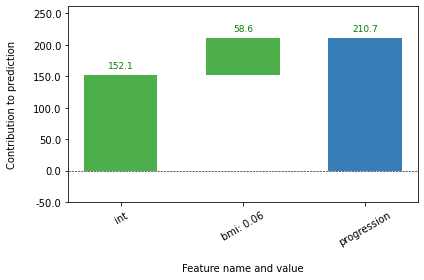

In [ ]:
ax = inspector.plot_waterfall(X.iloc[0])

Models with one or two features get an appropriate `.plot()` method:

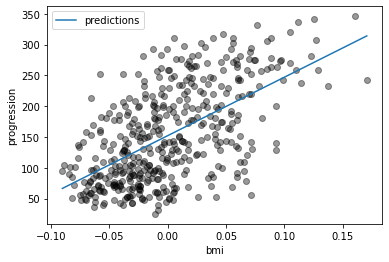

In [ ]:
ax = inspector.plot()

In [ ]:
# hide
show_doc(inspector.plot, name="plot", title_level=5)

<h5 id="plot" class="doc_header"><code>plot</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h5>

> <code>plot</code>(**`inspector`**:[`Inspector`](/model_inspector/inspect.html#Inspector), **`plot_data`**:`bool`=*`True`*, **`line_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`scatter_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`ax`**:`Optional`\[`Axes`\]=*`None`*)

Plot predictions from a regression or multiclass model with a
single input as a line

Parameters:
- `inspector`: [`Inspector`](/model_inspector/inspect.html#Inspector) object
- `plot_data`: Make a scatter plot of the data
- `line_kwargs`: kwargs to pass to `ax.plot` for plotting
predictions
- `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.

#### Decision Tree

In [ ]:
inspector = Inspector(DecisionTreeRegressor(max_depth=3).fit(X, y), X, y)

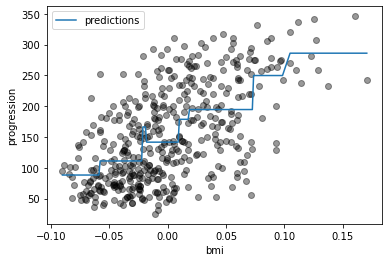

In [ ]:
ax = inspector.plot()

### Two Features

#### Linear Regression

In [ ]:
feature_cols = ["bmi", "bp"]
X = X_diabetes.loc[:, feature_cols]
inspector = Inspector(LinearRegression().fit(X, y), X, y)

In [ ]:
inspector.show_equation()

We can show the predictions from a model with two features as colors in a 2D plot:

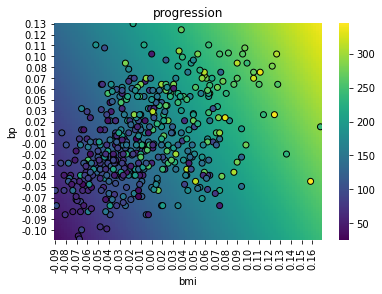

In [ ]:
ax = inspector.plot()

In [ ]:
# hide
show_doc(inspector.plot, name="plot", title_level=5)

<h5 id="plot" class="doc_header"><code>plot</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h5>

> <code>plot</code>(**`inspector`**:[`Inspector`](/model_inspector/inspect.html#Inspector), **`plot_data`**:`bool`=*`True`*, **`heatmap_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`scatter_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`tick_formatter`**:`Optional`\[`str`\]=*`'.2f'`*, **`ax`**=*`None`*)

Plot predictions from a model with two inputs as a heatmap.

Parameters:
- `inspector`: [`Inspector`](/model_inspector/inspect.html#Inspector) object
- `plot_data`: Make a scatter plot of the data
- `heatmap_kwargs`: kwargs to pass to `sns.heatmap` for plotting
predictions
- `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
- `tick_formatter`: Tick label format specifier
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.

Alternatively, we can plot those predictions in 3D:

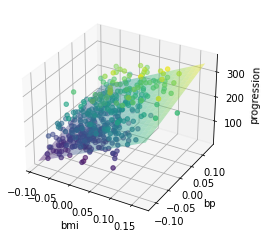

In [ ]:
ax = inspector.plot3d()

In [ ]:
# hide
show_doc(inspector.plot3d, name="plot3d", title_level=5)

<h5 id="plot3d" class="doc_header"><code>plot3d</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h5>

> <code>plot3d</code>(**`inspector`**:[`Inspector`](/model_inspector/inspect.html#Inspector), **`plot_data`**:`bool`=*`True`*, **`surf_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`scatter_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`ax`**=*`None`*)

Plot predictions from a model with two inputs as a surface.

Best viewed with a tool such as https://github.com/matplotlib/ipympl
that supports rotating the output

Parameters:
- `inspector`: [`Inspector`](/model_inspector/inspect.html#Inspector) object
- `plot_data`: Make a scatter plot of the data
- `surf_kwargs`: kwargs to pass to `ax.plot_surface` for plotting
predictions
- `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.

An interactive tool such as [ipyml](https://github.com/matplotlib/ipympl) makes it easier to see depth in these 3D plots:

In [ ]:
from IPython.display import Video

Video("https://github.com/gsganden/model_inspector/blob/master/docs/regression_3d.mov?raw=true")

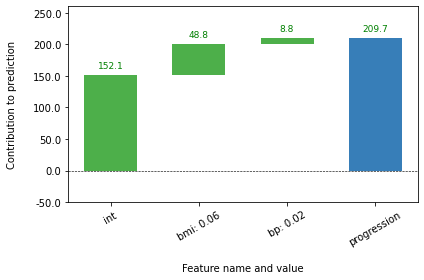

In [ ]:
ax = inspector.plot_waterfall(X.iloc[0].loc[feature_cols])

#### Decision Tree

In [ ]:
X = X_diabetes.loc[:, ["bmi", "bp"]]
inspector = Inspector(DecisionTreeRegressor(max_depth=3).fit(X, y), X, y)

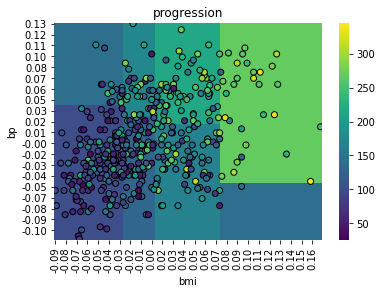

In [ ]:
ax = inspector.plot()

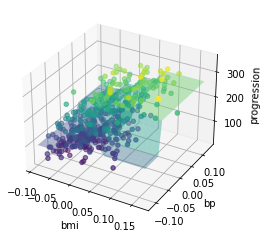

In [ ]:
ax = inspector.plot3d()

#### Random Forest

In [ ]:
model = RandomForestRegressor(max_depth=3)
X = X_diabetes.loc[:, ["bmi", "bp"]]
model.fit(X, y)
inspector = Inspector(model, X, y)

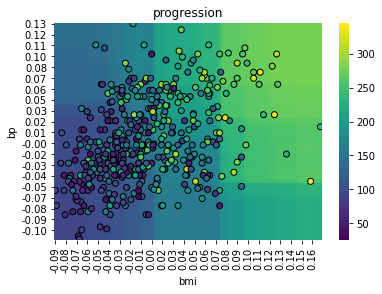

In [ ]:
ax = inspector.plot()

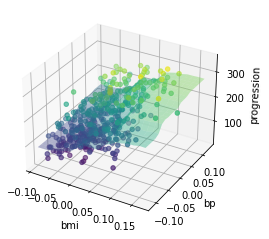

In [ ]:
ax = inspector.plot3d()

### Many Features

#### Ridge Regression

In [ ]:
model = Ridge(alpha=5)
X = X_diabetes
model.fit(X, y)
inspector = Inspector(model, X, y)

In [ ]:
inspector.show_equation()

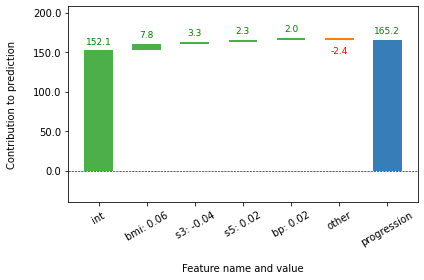

In [ ]:
ax = inspector.plot_waterfall(X.iloc[0])

We can plot the coefficients of linear and logistic regression models with hyperparameters against values of those hyperparameters:

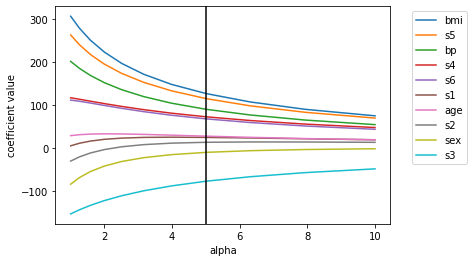

In [ ]:
axes = inspector.plot_coefs_vs_hparam(hparam="alpha", vals=np.logspace(0, 1, 11))

In [ ]:
# hide
show_doc(inspector.plot_coefs_vs_hparam, title_level=5)

<h5 id="LinRegInspector.plot_coefs_vs_hparam" class="doc_header"><code>LinRegInspector.plot_coefs_vs_hparam</code><a href="__main__.py#L5" class="source_link" style="float:right">[source]</a></h5>

> <code>LinRegInspector.plot_coefs_vs_hparam</code>(**`hparam`**:`str`, **`vals`**:`Sequence`\[`float`\])

Plot coefficient values against a hyperparameter

Parameters:
- `hparam`: Name of hyperparameter; must be an attribute of
`self.model`
- `vals`: Values of that hyperparameter to use

In [ ]:
# hide
show_doc(inspector.plot_correlation, title_level=5)

<h5 id="plot_correlation" class="doc_header"><code>plot_correlation</code><a href="https://github.com/gsganden/model_inspector/tree/master/model_inspector/explore.py#L14" class="source_link" style="float:right">[source]</a></h5>

> <code>plot_correlation</code>(**`df`**:`DataFrame`, **`ax`**:`Optional`\[`Axes`\]=*`None`*, **`heatmap_kwargs`**=*`None`*)

Create correlation heatmap

Parameters:
- `df`: DataFrame
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.
- `heatmap_kwargs`: kwargs to pass to `sns.heatmap`

## Classification

In [ ]:
iris = sklearn.datasets.load_iris()
X_iris, y_iris = iris["data"], iris["target"]
y_iris = pd.Series(y_iris, name="iris type").map(
    {num: name for num, name in zip([0, 1, 2], iris["target_names"])}
)
X_iris = pd.DataFrame(X_iris, columns=iris["feature_names"])

### One Feature

#### Binary Target

##### Logistic Regression

In [ ]:
X = X_iris.iloc[:, [0]]
y = y_iris == "setosa"
y.name = "setosa"
inspector = Inspector(LogisticRegression().fit(X, y), X, y)

In [ ]:
inspector.show_equation()

In [ ]:
# hide
show_doc(inspector.show_equation, title_level=5)

<h5 id="LogRegInspector.show_equation" class="doc_header"><code>LogRegInspector.show_equation</code><a href="__main__.py#L5" class="source_link" style="float:right">[source]</a></h5>

> <code>LogRegInspector.show_equation</code>(**`intercept_formatter`**:`str`=*`'.2f'`*, **`coef_formatter`**:`str`=*`'.2f'`*)

Show logistic model equation

Parameters:
- `intercept_formatter`: Intercept format specifier
- `coef_formatter`: Intercept format specifier

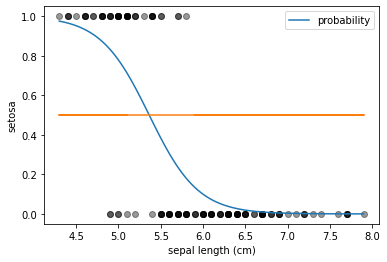

In [ ]:
ax = inspector.plot()

In [ ]:
# hide
show_doc(inspector.plot, name="plot", title_level=5)

<h5 id="plot" class="doc_header"><code>plot</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h5>

> <code>plot</code>(**`inspector`**:[`Inspector`](/model_inspector/inspect.html#Inspector), **`thresh`**:`Optional`\[`float`\]=*`0.5`*, **`plot_data`**:`bool`=*`True`*, **`prob_line_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`thresh_line_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`scatter_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`ax`**:`Optional`\[`Axes`\]=*`None`*)

Plot predictions from a binary classification model that provides
probabilities and has a single input

Parameters:
- `inspector`: [`Inspector`](/model_inspector/inspect.html#Inspector) object
- `thresh`: Threshold probability
- `plot_data`: Make a scatter plot of the data
- `prob_line_kwargs`: kwargs to pass to `ax.plot` for plotting
model probabilities
- `thresh_line_kwargs`: kwargs to pass to `ax.plot` for plotting
threshold
- `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.

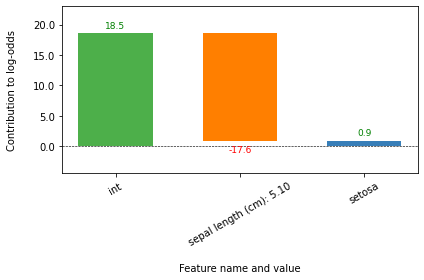

In [ ]:
ax = inspector.plot_waterfall(X.iloc[0])

In [ ]:
# hide
show_doc(inspector.plot_waterfall, name="plot_waterfall", title_level=5)

<h5 id="plot_waterfall" class="doc_header"><code>plot_waterfall</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h5>

> <code>plot_waterfall</code>(**`interp`**, **`item`**:`Union`\[`Series`, `array`\], **`bar_num_formatter`**:`str`=*`'.1f'`*, **`tick_num_formatter`**:`str`=*`'.2f'`*, **`waterfall_kwargs`**:`Optional`\[`dict`\]=*`None`*)

Make a waterfall chart showing how each feature contributes
to the prediction for the input item for a binary classification
model.

Parameters:
- `item`: Input item, with the same shape and value meanings as
a single row from `interp.X`
- `bar_num_formatter`: Bar label format specifier
- `tick_num_formatter`: Tick label format specifier
- ``waterfall_kwargs`: kwargs to pass to `waterfall_chart.plot`

##### Random Forest

In [ ]:
inspector = Inspector(RandomForestClassifier().fit(X, y), X, y)

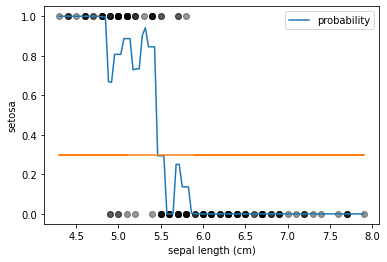

In [ ]:
ax = inspector.plot(thresh=.3)

##### Decision Tree

You can train a model on a training set and inspect it on a test set, for instance to show overfitting.

In [ ]:
random_state = 5
X_sample = X.sample(50, random_state=random_state)
X_train, X_test, y_train, y_test = train_test_split(X_sample, y.loc[X_sample.index], random_state=random_state)
model = DecisionTreeClassifier().fit(X_train, y_train)
inspector_train = Inspector(model, X_train, y_train)
inspector_test = Inspector(model, X_test, y_test)

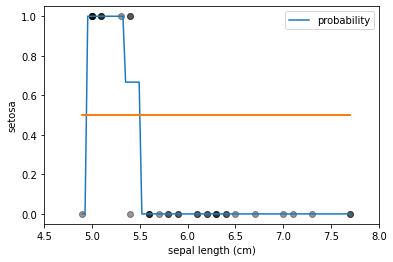

In [ ]:
ax = inspector_train.plot()
ax.set_xlim([4.5, 8]);

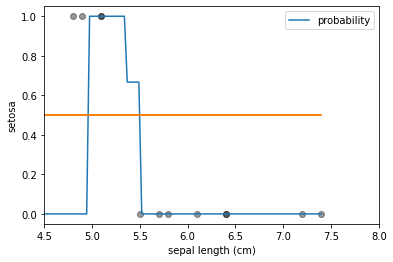

In [ ]:
ax = inspector_test.plot()
ax.set_xlim([4.5, 8]);

#### Multiclass Target

In [ ]:
y = y_iris
inspector = Inspector(LogisticRegression().fit(X, y), X, y)

In [ ]:
inspector.show_equation()

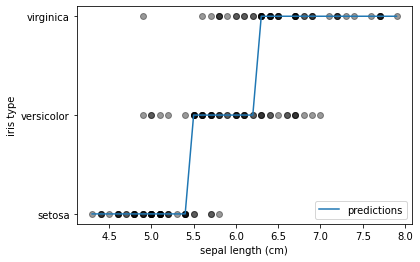

In [ ]:
ax = inspector.plot()

### Two Features

#### Binary Target

In [ ]:
X = X_iris.iloc[:, :2]
y = y_iris == "setosa"
y.name = "setosa"
inspector = Inspector(LogisticRegression().fit(X, y), X, y)

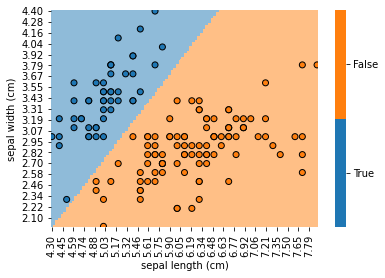

In [ ]:
ax = inspector.plot()

In [ ]:
# hide
show_doc(inspector.plot, name="plot", title_level=5)

<h5 id="plot" class="doc_header"><code>plot</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h5>

> <code>plot</code>(**`inspector`**:[`Inspector`](/model_inspector/inspect.html#Inspector), **`plot_data`**:`bool`=*`True`*, **`heatmap_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`scatter_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`tick_formatter`**:`Optional`\[`str`\]=*`'.2f'`*, **`ax`**=*`None`*)

Plot data and predictions for classification model with two features

Parameters:
- `inspector`: [`Inspector`](/model_inspector/inspect.html#Inspector) object
- `plot_data`: Make a scatter plot of the data
- `heatmap_kwargs`: kwargs to pass to `sns.heatmap` for plotting
predictions
- `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
- `tick_formatter`: Tick label format specifier
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.

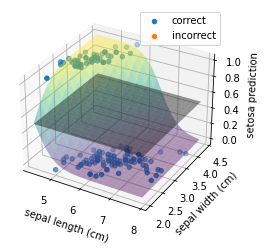

In [ ]:
ax = inspector.plot3d()

In [ ]:
# hide
show_doc(inspector.plot3d, name="plot3d", title_level=5)

<h5 id="plot3d" class="doc_header"><code>plot3d</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h5>

> <code>plot3d</code>(**`inspector`**:[`Inspector`](/model_inspector/inspect.html#Inspector), **`thresh`**=*`0.5`*, **`plot_prob`**:`bool`=*`True`*, **`plot_thresh`**:`bool`=*`True`*, **`plot_data`**:`bool`=*`True`*, **`prob_surf_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`thresh_surf_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`scatter_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`ax`**=*`None`*)

Plot data and predictions for binary classification model with 2
features in 3D

Best viewed with a tool such as https://github.com/matplotlib/ipympl
that supports rotating the output

Parameters:
- `inspector`: [`Inspector`](/model_inspector/inspect.html#Inspector) object
- `thresh`: Probability threshold for counting a prediction as
positive
- `plot_prob`: Whether to plot the model probabilities
- `plot_thresh`: Whether to plot a classification threshold
- `plot_data`: Whether to plot the data
- `prob_surf_kwargs`: kwargs to pass to the model probability
surface
- `thresh_surf_kwargs`: kwargs to pass to the threshold surface
- `scatter_kwargs`: kwargs to pass to the scatter plot of the data
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.

#### Multiclass Target

In [ ]:
y = y_iris
inspector = Inspector(LogisticRegression().fit(X, y), X, y)

In [ ]:
inspector.show_equation()

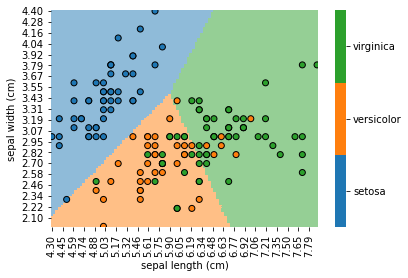

In [ ]:
ax = inspector.plot()

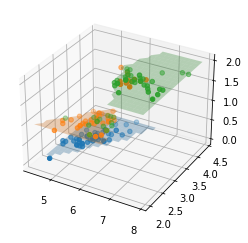

In [ ]:
ax = inspector.plot3d()

In [ ]:
# hide
show_doc(inspector.plot3d, name="plot3d", title_level=5)

<h5 id="plot3d" class="doc_header"><code>plot3d</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h5>

> <code>plot3d</code>(**`inspector`**:[`Inspector`](/model_inspector/inspect.html#Inspector), **`plot_data`**:`bool`=*`True`*, **`surf_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`scatter_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`ax`**=*`None`*)

Plot predictions from a model with two inputs as a surface.

Best viewed with a tool such as https://github.com/matplotlib/ipympl
that supports rotating the output

Parameters:
- `inspector`: [`Inspector`](/model_inspector/inspect.html#Inspector) object
- `plot_data`: Make a scatter plot of the data
- `surf_kwargs`: kwargs to pass to `ax.plot_surface` for plotting
predictions
- `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.

### Many Features

#### Binary Target

##### Logistic Regression

In [ ]:
X = X_iris
y = y_iris == "setosa"
y.name = "setosa"
inspector = Inspector(LogisticRegression().fit(X_iris, y), X_iris, y)

In [ ]:
inspector.show_equation()

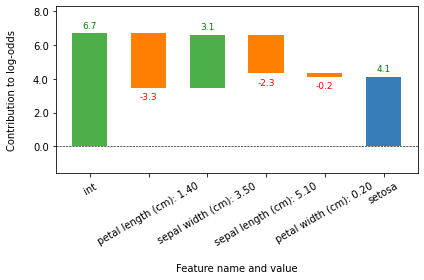

In [ ]:
ax = inspector.plot_waterfall(X.iloc[0])

#### Random Forest

In [ ]:
X_cancer, y_cancer = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)
X, y = X_cancer, y_cancer

In [ ]:
inspector = Inspector(RandomForestClassifier().fit(X, y), X, y)

An `Inspector` object for any binary classification model can run `calculate_metrics_by_thresh` from the `model_inspector.tune` module with `y_true=self.y` and `y_prob=self.model.predict(X)`:

/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:xlabel='thresh'>

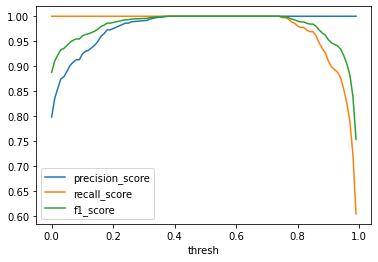

In [ ]:
def predict_true_if_prob_above_thresh(y_prob, thresh):
    return np.where(y_prob[:, 1] > thresh, 1, 0)
    

inspector.calculate_metrics_by_thresh(prob_to_pred=predict_true_if_prob_above_thresh, metrics=[metrics.precision_score, metrics.recall_score, metrics.f1_score]).iloc[:-1].plot(x="thresh")

In [ ]:
# hide
show_doc(inspector.calculate_metrics_by_thresh, title_level=5)

<h5 id="calculate_metrics_by_thresh" class="doc_header"><code>calculate_metrics_by_thresh</code><a href="https://github.com/gsganden/model_inspector/tree/master/model_inspector/tune.py#L15" class="source_link" style="float:right">[source]</a></h5>

> <code>calculate_metrics_by_thresh</code>(**`y_true`**:`array`, **`y_prob`**:`array`, **`prob_to_pred`**:`Union`\[`str`, `Callable`\], **`metrics`**:`Union`\[`Callable`, `Sequence`\[`Callable`\]\])

Calculate classification metrics as a function of threshold

Parameters:
- `y_true`: Ground-truth values
- `y_prob`: Probability distributions
- `prob_to_pred`: Callable that takes `y_prob` and `thresh` as positional
arguments and returns `y_pred`
- `metrics`: Callables that take `y_true`, `y_pred` as positional arguments
and return a number. Must have a `__name__` attribute.

Returns: DataFrame with one column "thresh" indicating the
thresholds used, which is 0 and the sorted set of values that occur in
`y_prob`, and an additional column for each input metric giving
the value of that metric at that threshold.

#### Multiclass Target

##### Logistic Regression

In [ ]:
X = X_iris
y = y_iris
inspector = Inspector(LogisticRegression(C=20, max_iter=1000).fit(X, y), X, y)

In [ ]:
inspector.show_equation()

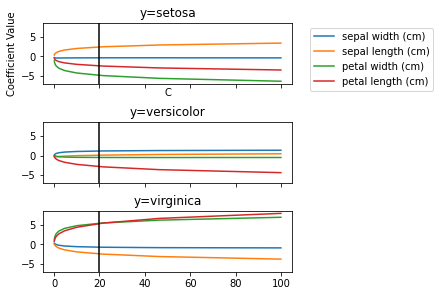

In [ ]:
axes = inspector.plot_coefs_vs_hparam(hparam="C", vals=np.logspace(-1, 2, 10))

In [ ]:
# hide
show_doc(inspector.plot_coefs_vs_hparam, title_level=5)

<h5 id="LogRegInspector.plot_coefs_vs_hparam" class="doc_header"><code>LogRegInspector.plot_coefs_vs_hparam</code><a href="__main__.py#L33" class="source_link" style="float:right">[source]</a></h5>

> <code>LogRegInspector.plot_coefs_vs_hparam</code>(**`hparam`**:`str`, **`vals`**:`Sequence`\[`float`\])

Plot coefficient values against a hyperparameter

Parameters:
- `hparam`: Name of hyperparameter; must be an attribute of
`self.model`
- `vals`: Values of that hyperparameter to use

##### Random Forest

Any `Inspector` object regardless of model type and data shape can run `plot_correlation` from the `model_inspector.explore` module on `pd.concat((self.X, self.y), axis="columns")`:

In [ ]:
inspector = Inspector(RandomForestClassifier().fit(X, y), X, y)

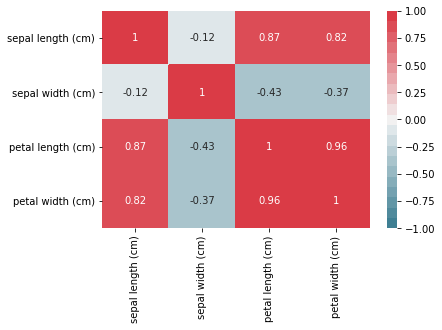

In [ ]:
ax = inspector.plot_correlation()

In [ ]:
show_doc(inspector.plot_correlation, title_level=5)

<h5 id="plot_correlation" class="doc_header"><code>plot_correlation</code><a href="https://github.com/gsganden/model_inspector/tree/master/model_inspector/explore.py#L14" class="source_link" style="float:right">[source]</a></h5>

> <code>plot_correlation</code>(**`df`**:`DataFrame`, **`ax`**:`Optional`\[`Axes`\]=*`None`*, **`heatmap_kwargs`**=*`None`*)

Create correlation heatmap

Parameters:
- `df`: DataFrame
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.
- `heatmap_kwargs`: kwargs to pass to `sns.heatmap`